In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMAI/Assignment3/
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SMAI/Assignment3
/content/drive/MyDrive/SMAI/Assignment3


In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imat
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import save_image
import os
import time
import gc
import shutil
import h5py
from PIL import Image
from sklearn.decomposition import PCA
%matplotlib inline

### Utility functions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_checkpoint(state, is_best, epoch, name):
    filename = 'q4_checkpoints/q4_ckpt_'+name
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, filename+'_best')

def plot_train(losses, errors):
    plt.plot(range(len(losses)), losses, label = "Train loss", color='blue', markersize=5, marker='o',markerfacecolor='blue')
    plt.plot(range(len(errors)), errors, label = "Val loss", color='red', markersize=5, marker='o',markerfacecolor='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Val loss')
    plt.legend()
    plt.show()

# **1) Siamese Net with Contrastive loss**

### Creating Siamese dataloader

In [ ]:
class SiameseDataloader():
    def __init__(self, batch_size=64):
        self.batch_size = batch_size
        self.data_index = 0
        self.train_dataloader = None
        self.test_dataloader = None
        self.workers = 2

    def load_dataset(self, train):
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
        os.makedirs("data/mnist", exist_ok=True)
        train_dataset = MNIST(root='data/mnist', train=True, download=True, transform=transform)
        test_dataset = MNIST(root='data/mnist', train=False, transform=transform)
        # print(len(train_dataset), len(test_dataset))
        self.train_dataloader = DataLoader(train_dataset, self.batch_size, shuffle=True) 
        self.test_dataloader = DataLoader(test_dataset, 1, shuffle=True)
        if train:
            return train_dataset
        else:
            return test_dataset
        
    def generate_batch(self, train):
        if train:
            data_iter = iter(self.train_dataloader)
        else:
            data_iter = iter(self.test_dataloader)
        input_1, label_1 = next(data_iter)
        input_2, label_2 = next(data_iter)
        # print(type(input_1),type(label_1))
        np_label_1 = label_1
        np_label_2 = label_2
        label = (np_label_1 == np_label_2).float()
        return input_1, input_2, label

### Defining Simaese network

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, ctl=False):
        super(SiameseNet, self).__init__()
        self.ctl = ctl
        self.convblock = nn.Sequential(
            nn.Conv2d(1, 32, 5), 
            nn.PReLU(), 
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3), 
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.denseblock = nn.Sequential(
            nn.Linear(1600, 512),
            nn.PReLU(),
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Linear(256, 8)
        )
        self.catblock = nn.Sequential(
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        X = self.convblock(x)
        X = X.view(X.size()[0], -1)
        # print(X.shape)
        X = self.denseblock(X)
        return X

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        if self.ctl:
            return output1, output2
        else:
            output = torch.cat((output1, output2), 1)
            output = self.catblock(output)
            return output

### Defining Contrastive loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, x0, x1, y):
        euclid_dists = (x1 - x0).pow(2).sum(1)
        losses = 0.5 * (y * euclid_dists + (1 - y) * nn.functional.relu(self.margin - (euclid_dists + self.eps).sqrt()).pow(2))
        # print('losses',losses)
        return losses.mean()

### Defining Siamese trainer

In [ ]:
class Siamese_Trainer(object):
    def __init__(self, device, ckpt_name, load_ckpt=None, losstype=None, epochs=200, batch_size=128, lr=0.1, optm=None, mom=0.9, weight_decay=0):
        self.device = device
        self.lr =  lr
        self.momentum = mom
        self.batch_size = batch_size
        self.start_epoch = 0
        self.epochs = epochs
        self.workers = 0
        self.seed = int(time.time())
        self.print_freq = 1
        self.checkpoint_path = load_ckpt #'q1_checkpoints/q1_ckpt_CNN_a_best2'
        self.best_error = 1e8
        self.best_epoch = 0
        self.ckpt_name = ckpt_name
        self.loss_history = []
        self.error_history = []
        self.weight_decay = weight_decay
        self.losstype = losstype

        torch.cuda.manual_seed(self.seed)
        print(self.device,torch.cuda.get_device_name(0))

        self.model = SiameseNet(ctl=False).cuda() if losstype=='CE' else SiameseNet().cuda()
        # print(self.model)
        if optm=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optm=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr, weight_decay=self.weight_decay)
        elif optm=='rms':
            self.optimizer = torch.optim.RMSprop(self.model.parameters(), self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        self.criterion = nn.BCELoss().cuda() if losstype=='CE' else ContrastiveLoss().cuda()
        
        if self.checkpoint_path:
            checkpoint = torch.load(self.checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.start_epoch = checkpoint['epoch']+1
            loss = checkpoint['loss']
            self.best_error = checkpoint['best_error']
            self.best_epoch = checkpoint['best_epoch']
        
    def train(self):
        for epoch in range(self.start_epoch, self.epochs):
            self.dataloader = SiameseDataloader()
            trainset = self.dataloader.load_dataset(True)
            valset = self.dataloader.load_dataset(False)
            train_loader_size = round(len(trainset) / self.batch_size)
            val_loader_size = round(len(valset) / self.batch_size)
            loss = 0
            error = 0
            if self.losstype=='CE':
                for t_batch in range(0,train_loader_size):
                    loss += self.train_epoch_CE(t_batch)
                for v_batch in range(0,val_loader_size):
                    error += self.validate_CE(v_batch)
            else:
                for t_batch in range(0,train_loader_size):
                    loss += self.train_epoch_CT(t_batch)
                for v_batch in range(0,val_loader_size):
                    error += self.validate_CT(v_batch)
            loss /= train_loader_size            
            error /= val_loader_size
            if error < self.best_error:
                is_best = True
                self.best_epoch = epoch
            else:
                is_best = False
            self.loss_history.append(loss)
            self.error_history.append(error)
            self.best_error = min(error, self.best_error)
            print('Epoch:'+str(epoch),'  Loss:'+str(round(loss,3)),'  Val error:'+str(round(error,3)),'  Best val error:'+str(round(self.best_error,3)))
            save_checkpoint({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': loss,
                'best_error': self.best_error,
                'best_epoch': self.best_epoch
            }, is_best, epoch, self.ckpt_name)
        return self.best_epoch, self.loss_history, self.error_history

    def train_epoch_CT(self, cur_epoch):        
        loss = 0
        out_imgs = None
        input1, input2, target = self.dataloader.generate_batch(True)
        input1 = input1.to(self.device)
        input2 = input2.to(self.device)
        # plt.figure(dpi=100)
        # plt.margins(0,0)
        # plt.imshow(input1[0][0].cpu().numpy())
        # plt.figure(dpi=100)
        # plt.margins(0,0)
        # plt.imshow(input2[0][0].cpu().numpy())
        target = target.to(self.device)
        # print('label',target)
        with torch.set_grad_enabled(True):
            out1, out2 = self.model(input1, input2)
            loss = self.criterion(out1, out2, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        torch.cuda.empty_cache()
        gc.collect()
        # print(loss.item())
        # input()
        return loss.detach().cpu().item()

    def train_epoch_CE(self, cur_epoch):        
        loss = 0
        out_imgs = None
        input1, input2, target = self.dataloader.generate_batch(True)
        input1 = input1.to(self.device)
        input2 = input2.to(self.device)
        target = target.to(self.device)
        with torch.set_grad_enabled(True):
            output = self.model(input1, input2).squeeze(-1)
            # euclid_dists = torch.sigmoid((out2 - out1).pow(2).sum(1))
            # euclid_dists = torch.sigmoid(out1 * out2).squeeze(-1)
            # print(euclid_dists.shape, target.shape)
            loss = self.criterion(output, target)
            # print(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        torch.cuda.empty_cache()
        gc.collect()
        return loss.detach().cpu().item()
    
    def validate_CT(self, cur_epoch):     
        self.model.eval()        
        loss = 0
        out_imgs = None
        input1, input2, target = self.dataloader.generate_batch(False)
        input1 = input1.to(self.device)
        input2 = input2.to(self.device)
        target = target.to(self.device)
        with torch.set_grad_enabled(False):
            out1, out2 = self.model(input1, input2)
            loss = self.criterion(out1, out2, target)
        torch.cuda.empty_cache()
        gc.collect()
        return loss.detach().cpu().item()

    def validate_CE(self, cur_epoch):     
        self.model.eval()        
        loss = 0
        out_imgs = None
        input1, input2, target = self.dataloader.generate_batch(False)
        input1 = input1.to(self.device)
        input2 = input2.to(self.device)
        target = target.to(self.device)
        with torch.set_grad_enabled(False):
            output = self.model(input1, input2).squeeze(-1)
            loss = self.criterion(output, target)
        torch.cuda.empty_cache()
        gc.collect()
        return loss.detach().cpu().item()


### Training SiameseNet with Contrastive loss and Adam optimizer

cuda Tesla T4
Epoch:0   Loss:0.103   Val error:0.117   Best val error:0.117
Epoch:1   Loss:0.076   Val error:0.051   Best val error:0.051
Epoch:2   Loss:0.065   Val error:0.056   Best val error:0.051
Epoch:3   Loss:0.059   Val error:0.039   Best val error:0.039
Epoch:4   Loss:0.054   Val error:0.046   Best val error:0.039
Epoch:5   Loss:0.051   Val error:0.048   Best val error:0.039
Epoch:6   Loss:0.049   Val error:0.043   Best val error:0.039
Epoch:7   Loss:0.048   Val error:0.101   Best val error:0.039
Epoch:8   Loss:0.044   Val error:0.03   Best val error:0.03
Epoch:9   Loss:0.04   Val error:0.025   Best val error:0.025
Epoch:10   Loss:0.037   Val error:0.027   Best val error:0.025
Epoch:11   Loss:0.035   Val error:0.028   Best val error:0.025
Epoch:12   Loss:0.033   Val error:0.036   Best val error:0.025
Epoch:13   Loss:0.034   Val error:0.024   Best val error:0.024
Epoch:14   Loss:0.031   Val error:0.032   Best val error:0.024
Epoch:15   Loss:0.028   Val error:0.013   Best val err

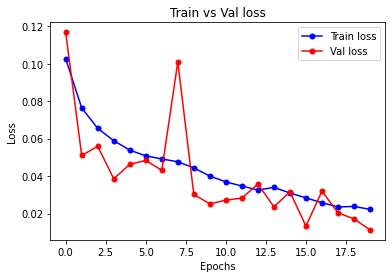

Best epoch: 19


In [ ]:
sma_trainer = Siamese_Trainer(device, 'Siam_a', lr=0.0001, epochs=20, optm='adam', mom=0.9)
sma_best_epoch, sma_losses, sma_errors = sma_trainer.train()
plot_train(sma_losses, sma_errors)
print('Best epoch:',sma_best_epoch)

### Training SiameseNet with Contrastive loss and SGD optimizer

cuda Tesla T4
Epoch:0   Loss:0.4   Val error:0.347   Best val error:0.347
Epoch:1   Loss:0.251   Val error:0.155   Best val error:0.155
Epoch:2   Loss:0.144   Val error:0.121   Best val error:0.121
Epoch:3   Loss:0.123   Val error:0.104   Best val error:0.104
Epoch:4   Loss:0.116   Val error:0.134   Best val error:0.104
Epoch:5   Loss:0.117   Val error:0.085   Best val error:0.085
Epoch:6   Loss:0.113   Val error:0.098   Best val error:0.085
Epoch:7   Loss:0.112   Val error:0.081   Best val error:0.081
Epoch:8   Loss:0.111   Val error:0.13   Best val error:0.081
Epoch:9   Loss:0.109   Val error:0.088   Best val error:0.081
Epoch:10   Loss:0.11   Val error:0.074   Best val error:0.074
Epoch:11   Loss:0.106   Val error:0.126   Best val error:0.074
Epoch:12   Loss:0.105   Val error:0.111   Best val error:0.074
Epoch:13   Loss:0.102   Val error:0.135   Best val error:0.074
Epoch:14   Loss:0.103   Val error:0.095   Best val error:0.074
Epoch:15   Loss:0.101   Val error:0.088   Best val erro

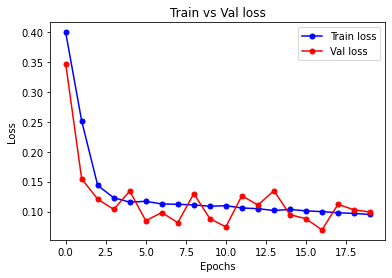

Best epoch: 16


In [ ]:
sms_trainer = Siamese_Trainer(device, 'Siam_s', lr=0.0001, epochs=20, optm='sgd', mom=0.9)
sms_best_epoch, sms_losses, sms_errors = sms_trainer.train()
plot_train(sms_losses, sms_errors)
print('Best epoch:',sms_best_epoch)

### Training SiameseNet with Contrastive loss and RMSprop optimizer



cuda Tesla T4
Epoch:0   Loss:0.104   Val error:0.065   Best val error:0.065
Epoch:1   Loss:0.082   Val error:0.089   Best val error:0.065
Epoch:2   Loss:0.073   Val error:0.061   Best val error:0.061
Epoch:3   Loss:0.063   Val error:0.085   Best val error:0.061
Epoch:4   Loss:0.056   Val error:0.052   Best val error:0.052
Epoch:5   Loss:0.045   Val error:0.017   Best val error:0.017
Epoch:6   Loss:0.039   Val error:0.034   Best val error:0.017
Epoch:7   Loss:0.033   Val error:0.031   Best val error:0.017
Epoch:8   Loss:0.027   Val error:0.008   Best val error:0.008
Epoch:9   Loss:0.03   Val error:0.014   Best val error:0.008
Epoch:10   Loss:0.026   Val error:0.036   Best val error:0.008
Epoch:11   Loss:0.026   Val error:0.021   Best val error:0.008
Epoch:12   Loss:0.023   Val error:0.017   Best val error:0.008
Epoch:13   Loss:0.022   Val error:0.013   Best val error:0.008
Epoch:14   Loss:0.021   Val error:0.015   Best val error:0.008
Epoch:15   Loss:0.025   Val error:0.021   Best val e

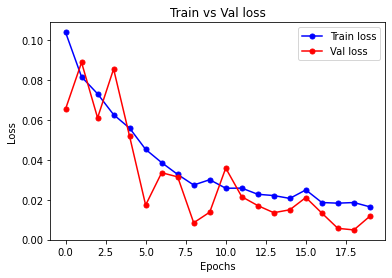

Best epoch: 18


In [ ]:
smr_trainer = Siamese_Trainer(device, 'Siam_r', lr=0.0001, epochs=20, optm='rms', mom=0.9)
smr_best_epoch, smr_losses, smr_errors = smr_trainer.train()
plot_train(smr_losses, smr_errors)
print('Best epoch:',smr_best_epoch)

--------------------------------------------------------------------------------

# **2) SiameseNet with regularized cross entropy loss**

### Training SiameseNet with regularized cross entropy loss and Adam optimizer

cuda Tesla T4
Epoch:0   Loss:0.71   Val error:0.575   Best val error:0.575
Epoch:1   Loss:0.467   Val error:0.33   Best val error:0.33
Epoch:2   Loss:0.349   Val error:0.238   Best val error:0.238
Epoch:3   Loss:0.33   Val error:0.302   Best val error:0.238
Epoch:4   Loss:0.324   Val error:0.304   Best val error:0.238
Epoch:5   Loss:0.328   Val error:0.275   Best val error:0.238
Epoch:6   Loss:0.323   Val error:0.218   Best val error:0.218
Epoch:7   Loss:0.322   Val error:0.479   Best val error:0.218
Epoch:8   Loss:0.33   Val error:0.362   Best val error:0.218
Epoch:9   Loss:0.332   Val error:0.387   Best val error:0.218
Epoch:10   Loss:0.325   Val error:0.437   Best val error:0.218
Epoch:11   Loss:0.33   Val error:0.245   Best val error:0.218
Epoch:12   Loss:0.322   Val error:0.214   Best val error:0.214
Epoch:13   Loss:0.33   Val error:0.331   Best val error:0.214
Epoch:14   Loss:0.328   Val error:0.25   Best val error:0.214
Epoch:15   Loss:0.329   Val error:0.219   Best val error:0.

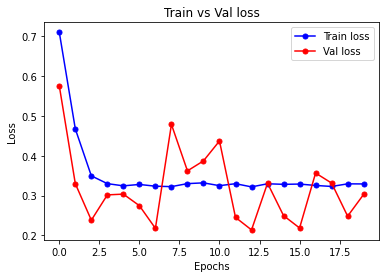

Best epoch: 12


In [ ]:
ema_trainer = Siamese_Trainer(device, 'Ent_a', lr=0.000001, epochs=20, optm='adam', mom=0.9, losstype='CE', weight_decay=1e-4)
ema_best_epoch, ema_losses, ema_errors = ema_trainer.train()
plot_train(ema_losses, ema_errors)
print('Best epoch:',ema_best_epoch)

-------------------------------------------------------------------------------

# **3) Siamese - TripletNet**

### Creating dataloader for Siamese TripleNet

In [ ]:
def load_dataset():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
    os.makedirs("data/mnist", exist_ok=True)
    train_dataset = MNIST(root='data/mnist', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='data/mnist', train=False, transform=transform)
    # print(len(train_dataset), len(test_dataset))
    return train_dataset, test_dataset

class TripletDataloader():
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(10)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        # print(type(img1),img1.size)
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3), []

    def __len__(self):
        return len(self.mnist_dataset)

### Defining TripletNet

In [ ]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet, self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(1, 32, 5), 
            nn.PReLU(), 
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3), 
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.denseblock = nn.Sequential(
            nn.Linear(1600, 512),
            nn.PReLU(),
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Linear(256, 1)
        )

    def forward_once(self, x):
        X = self.convblock(x)
        X = X.view(X.size()[0], -1)
        # print(X.shape)
        X = self.denseblock(X)
        return X

    def forward(self, x1, x2, x3):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        output3 = self.forward_once(x3)
        return output1, output2, output3

### Defining Triplet loss

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = nn.functional.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [ ]:
class Triplet_Trainer(object):
    def __init__(self, device, ckpt_name, load_ckpt=None, epochs=200, batch_size=128, lr=0.1, optm=None, mom=0.9, weight_decay=0):
        self.device = device
        self.lr =  lr
        self.momentum = mom
        self.batch_size = batch_size
        self.start_epoch = 0
        self.epochs = epochs
        self.workers = 0
        self.seed = int(time.time())
        self.print_freq = 1
        self.checkpoint_path = load_ckpt #'q1_checkpoints/q1_ckpt_CNN_a_best2'
        self.best_error = 1e8
        self.best_epoch = 0
        self.ckpt_name = ckpt_name
        self.loss_history = []
        self.error_history = []

        torch.cuda.manual_seed(self.seed)
        print(self.device,torch.cuda.get_device_name(0))

        self.model = TripletNet().cuda()
        # print(self.model)
        if optm=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=self.momentum)
        elif optm=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        elif optm=='rms':
            self.optimizer = torch.optim.RMSprop(self.model.parameters(), self.lr, momentum=self.momentum)
        self.criterion = TripletLoss().cuda()
        
        if self.checkpoint_path:
            checkpoint = torch.load(self.checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.start_epoch = checkpoint['epoch']+1
            loss = checkpoint['loss']
            self.best_error = checkpoint['best_error']
            self.best_epoch = checkpoint['best_epoch']
        
    def train(self):
        for epoch in range(self.start_epoch, self.epochs):
            trainset, valset = load_dataset()
            self.train_loader = torch.utils.data.DataLoader(TripletDataloader(trainset), batch_size=self.batch_size, shuffle=True)
            self.val_loader = torch.utils.data.DataLoader(TripletDataloader(valset), batch_size=self.batch_size, shuffle=False)
            loss = self.train_epoch(epoch)
            if epoch%1 != 0:
                print('Epoch:'+str(epoch),'  Loss:'+str(round(loss,3)))
                continue
            error = self.validate(epoch)
            if error < self.best_error:
                is_best = True
                self.best_epoch = epoch
            else:
                is_best = False
            self.loss_history.append(loss)
            self.error_history.append(error)
            self.best_error = min(error, self.best_error)
            print('Epoch:'+str(epoch),'  Loss:'+str(round(loss,3)),'  Val error:'+str(round(error,3)),'  Best val error:'+str(round(self.best_error,3)))
            save_checkpoint({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': loss,
                'best_error': self.best_error,
                'best_epoch': self.best_epoch
            }, is_best, epoch, self.ckpt_name)
            # break
        return self.best_epoch, self.loss_history, self.error_history

    def train_epoch(self, cur_epoch):        
        losses = 0
        self.model.train()
        for bix, (data, target) in enumerate(self.train_loader):
            # print(type(data),type(target))
            # print(data, target)
            (anchor, positive, negative) = data
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            # plt.figure(dpi=100)
            # plt.margins(0,0)
            # plt.imshow(anchor[1][0].cpu().numpy())
            # plt.figure(dpi=100)
            # plt.margins(0,0)
            # plt.imshow(positive[1][0].cpu().numpy())
            # plt.figure(dpi=100)
            # plt.margins(0,0)
            # plt.imshow(negative[1][0].cpu().numpy())
            with torch.set_grad_enabled(True):
                out_a, out_p, out_n = self.model(anchor, positive, negative)
                loss = self.criterion(out_a, out_p, out_n)
                losses += loss.detach().cpu().item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            torch.cuda.empty_cache()
            gc.collect()
            # break
        # print(loss.item())
        # input()
        return losses/len(self.train_loader)
    
    def validate(self, cur_epoch):     
        losses = 0
        self.model.eval()
        for bix, (data, target) in enumerate(self.train_loader):
            (anchor, positive, negative) = data
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            # plt.figure(dpi=10)
            # plt.margins(0,0)
            # plt.imshow(anchor[1][0].cpu().numpy())
            # plt.figure(dpi=10)
            # plt.margins(0,0)
            # plt.imshow(positive[1][0].cpu().numpy())
            # plt.figure(dpi=10)
            # plt.margins(0,0)
            # plt.imshow(negative[1][0].cpu().numpy())
            with torch.set_grad_enabled(False):
                out_a, out_p, out_n = self.model(anchor, positive, negative)
                loss = self.criterion(out_a, out_p, out_n)
                losses += loss.detach().cpu().item()
            torch.cuda.empty_cache()
            gc.collect()
            # break
        # print(loss.item())
        # input()
        return losses/len(self.train_loader)


### Training SiameseNet with Triplet loss and Adam optimizer

cuda Tesla T4
Epoch:0   Loss:0.301   Val error:0.184   Best val error:0.184
Epoch:1   Loss:0.164   Val error:0.123   Best val error:0.123
Epoch:2   Loss:0.134   Val error:0.111   Best val error:0.111
Epoch:3   Loss:0.106   Val error:0.089   Best val error:0.089
Epoch:4   Loss:0.088   Val error:0.059   Best val error:0.059
Epoch:5   Loss:0.068   Val error:0.094   Best val error:0.059
Epoch:6   Loss:0.067   Val error:0.056   Best val error:0.056
Epoch:7   Loss:0.057   Val error:0.037   Best val error:0.037
Epoch:8   Loss:0.043   Val error:0.041   Best val error:0.037
Epoch:9   Loss:0.032   Val error:0.028   Best val error:0.028
Epoch:10   Loss:0.039   Val error:0.057   Best val error:0.028
Epoch:11   Loss:0.036   Val error:0.025   Best val error:0.025
Epoch:12   Loss:0.029   Val error:0.021   Best val error:0.021
Epoch:13   Loss:0.021   Val error:0.013   Best val error:0.013
Epoch:14   Loss:0.02   Val error:0.027   Best val error:0.013
Epoch:15   Loss:0.025   Val error:0.026   Best val e

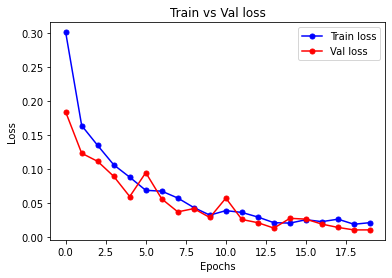

Best epoch: 18


In [ ]:

tma_trainer = Triplet_Trainer(device, 'Trip_a', lr=0.001, epochs=20, optm='adam', mom=0.9)
tma_best_epoch, tma_losses, tma_errors = tma_trainer.train()
plot_train(tma_losses, tma_errors)
print('Best epoch:',tma_best_epoch)